In [5]:
import os
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

In [ ]:
OUTDIR = "../results/08.iterative_clustering/"
os.path.exists(OUTDIR) or os.makedirs(OUTDIR)

In [4]:
adata = sc.read("../results/07.label_transfer.mouse/mTCA.core.h5ad")
sc.pp.filter_genes(adata, min_counts=3)
adata = adata[adata.obs['Cell_QC'] == "High"] # only keep high qual cells
adata = adata[adata.obs['GSE_ID'] != "GSE113293"] # drop elife 2019 dataset
adata.layers["counts"] = adata.X.tocsr()
adata.raw = adata  # keep full dimension safe

Only considering the two last: ['.raw_counts', '.h5ad'].
Only considering the two last: ['.raw_counts', '.h5ad'].


In [5]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="GSE_ID",
    subset=True
)

In [6]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="GSM_ID")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()

INFO     Using batches from adata.obs["GSM_ID"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 189822 cells, 2000 vars, 227      
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 42/42: 100%|███████████████████████████████████| 42/42 [18:29<00:00, 26.42s/it, loss=764, v_num=1]


In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

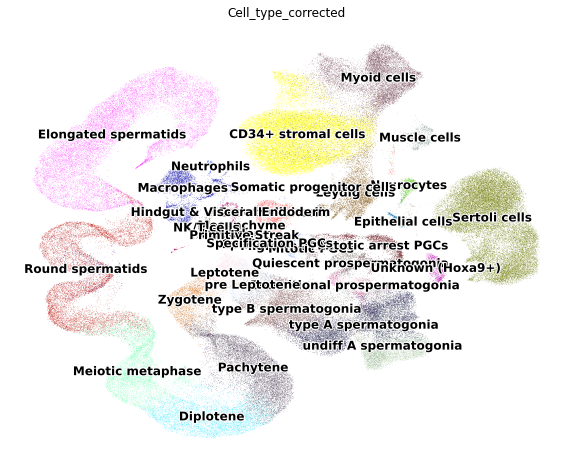

In [6]:
with rc_context({'figure.figsize': (10, 8)}):
    sc.pl.umap(adata, color=["Cell_type_corrected"], 
               frameon=False, ncols=1,
               legend_loc='on data', legend_fontsize=12, legend_fontoutline=2)

In [8]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="GSM_ID",
    labels_key="Cell_type_corrected",
)

lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    unlabeled_category="Unknown",
    adata=adata
)

INFO     Using batches from adata.obs["GSM_ID"]                                              
INFO     Using labels from adata.obs["Cell_type_corrected"]                                  
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 189822 cells, 2000 vars, 227      
         batches, 35 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [9]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                             


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 20/20: 100%|███████████████████████████████████| 20/20 [21:23<00:00, 64.18s/it, loss=920, v_num=1]


In [10]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [11]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

In [10]:
sc.tl.leiden(adata, resolution=.1, key_added="leiden_r1")

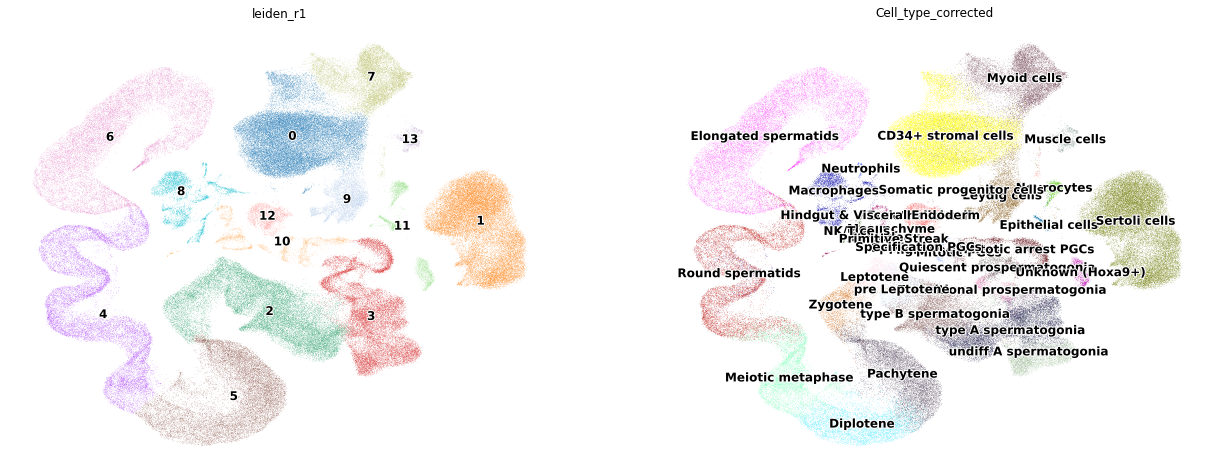

In [11]:
with rc_context({'figure.figsize': (10, 8)}):
    sc.pl.umap(adata, color=["leiden_r1","Cell_type_corrected"], 
               frameon=False, ncols=2,
               legend_loc='on data', legend_fontsize=12, legend_fontoutline=2)

In [12]:
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r2", restrict_to=("leiden_r1", ["10"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r2", restrict_to=("leiden_r2", ["2"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r2", restrict_to=("leiden_r2", ["3"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r2", restrict_to=("leiden_r2", ["11"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r2", restrict_to=("leiden_r2", ["4"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r2", restrict_to=("leiden_r2", ["5"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r2", restrict_to=("leiden_r2", ["8"]))

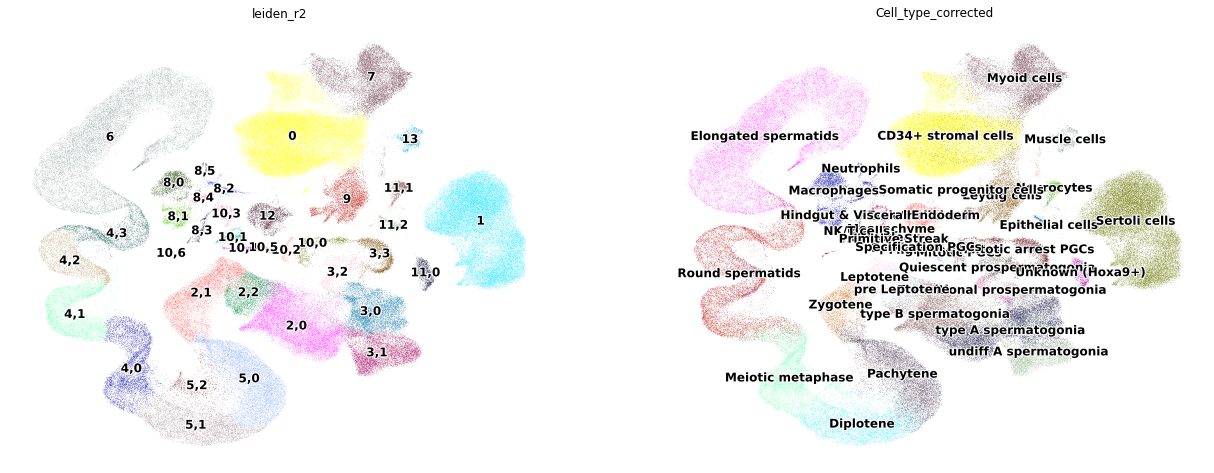

In [13]:
with rc_context({'figure.figsize': (10, 8)}):
    sc.pl.umap(adata, color=["leiden_r2","Cell_type_corrected"], 
               frameon=False, ncols=2,
               legend_loc='on data', legend_fontsize=12, legend_fontoutline=2)

In [14]:
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r3", restrict_to=("leiden_r2", ["5,2"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r3", restrict_to=("leiden_r3", ["2,1"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r3", restrict_to=("leiden_r3", ["3,2"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r3", restrict_to=("leiden_r3", ["3,0"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r3", restrict_to=("leiden_r3", ["2,0"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r3", restrict_to=("leiden_r3", ["2,2"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r3", restrict_to=("leiden_r3", ["10,1"]))
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r3", restrict_to=("leiden_r3", ["10,0"]))

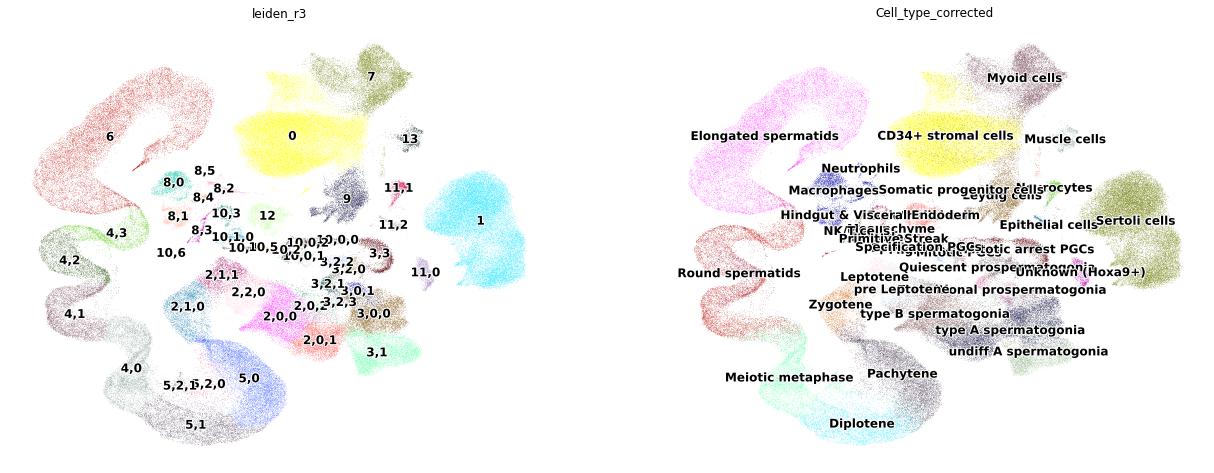

In [15]:
with rc_context({'figure.figsize': (10, 8)}):
    sc.pl.umap(adata, color=["leiden_r3","Cell_type_corrected"], 
               frameon=False, ncols=2,
               legend_loc='on data', legend_fontsize=12, legend_fontoutline=2)

In [16]:
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_r4", restrict_to=("leiden_r3", ["2,1,0"]))

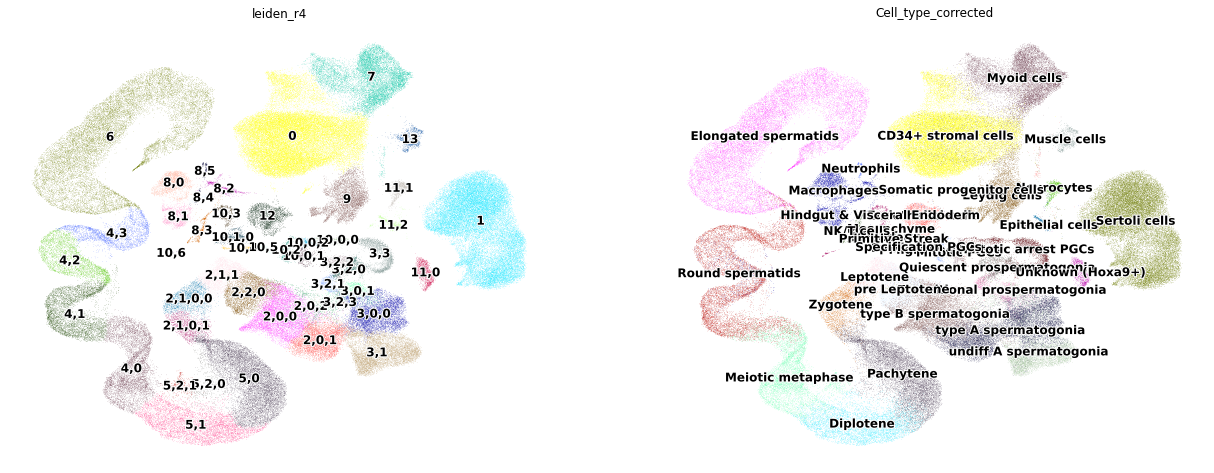

In [17]:
with rc_context({'figure.figsize': (10, 8)}):
    sc.pl.umap(adata, color=["leiden_r4","Cell_type_corrected"], 
               frameon=False, ncols=2,
               legend_loc='on data', legend_fontsize=12, legend_fontoutline=2)

In [25]:
emb = pd.DataFrame(adata.obsm['X_umap'])
emb.columns = ["UMAP_1", "UMAP_2"]
emb.index = adata.obs.index
emb['leiden_r1'] = adata.obs["leiden_r1"]
emb['leiden_r2'] = adata.obs["leiden_r2"]
emb['leiden_r3'] = adata.obs["leiden_r3"]
emb['leiden_r4'] = adata.obs["leiden_r4"]

emb.to_csv("../results/08.iterative_clustering/mTCA_cellmeta_iter_clusters.csv")

In [26]:
adata.write_h5ad("../results/08.iterative_clustering/mTCA_iter_clusters.h5ad")